# Using Time Series to more accurately predict wave heights

In [1]:
import utilities.misc as misc
import utilities.metrics as mtr
import utilities.ml_functions as ml
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math 
import numpy as np
from matplotlib import cm
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, train_test_split

In [2]:
# convert datetime to unix
# df = pd.read_csv('clean_weather/valid_dates/m1_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m1_valid.csv')
df = pd.read_csv('clean_weather/valid_dates/m2_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m2_valid.csv')

start_date = min(df['time'])
end_date = max(df['time'])

df['timestamps'] = (df['date'] + ' ' +df['time'])
df['timestamps'] = pd.to_datetime(df['timestamps'])
df['timestamps'] = (df['timestamps'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  

df.head()


,Unnamed: 0,time,station_id,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,SeaTemperature,date,timestamps
0,1953,00:00:00,M2,1020.0,330.0,2.92,3.9,0.6,4.0,NaN,NaN,8.6,2001-05-05,989020800
1,1955,01:00:00,M2,1020.8,330.0,4.09,5.8,0.4,4.0,NaN,NaN,8.6,2001-05-05,989024400
2,1957,02:00:00,M2,1020.8,350.0,4.09,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989028000
3,1959,03:00:00,M2,1021.2,350.0,1.95,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989031600
4,1961,04:00:00,M2,1021.4,30.0,2.92,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989035200


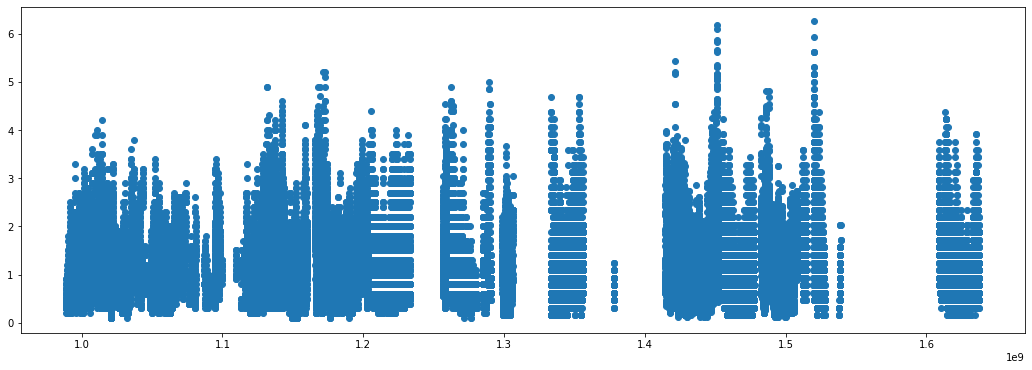

In [3]:
plt.figure(figsize=(18,6))

plt.scatter(df['timestamps'], df['WaveHeight'])
# plt.plot(df['timestamps'], df['WaveHeight'], color = 'red')


### Need to cut data into these chunks then try to predict

In [4]:
def chunkify(hours:int, dataframe:pd.DataFrame):
    """
    Splits dataframe into time chunks

    Parameters
    ----------
    hours : int

    dataframe : pandas.Dataframe

    Returns
    ----------
    chunk_df : pandas.Dataframe
    
    """
    num_hrs = len(df)
    # hours = 24
    num_chunks = int(num_hrs/hours)
    cols = []

    data = []
    for i in range(hours):
        cols.append(f"wind{i+1}")
        cols.append(f"wave{i+1}")
        cols.append(f"atmo{i+1}")

    chunk_df =pd.DataFrame(columns=[cols])

    for j in range(num_chunks):
        # for i in range(hours):
        #     wind.append(df['WindSpeed'][i])
        #     wave.append(df['WaveHeight'][i])
        #     atmo.append(df['AtmosphericPressure'][i])
        data = []

        for i in range(j*hours,j*hours+hours ):
            data.append(dataframe['WindSpeed'][i])
            data.append(dataframe['WaveHeight'][i])
            data.append(dataframe['AtmosphericPressure'][i])
        
        chunk_df.loc[len(chunk_df)] = data

    return chunk_df

In [5]:
def select_features(start_col: int, end_col: int, y_col: int, dataframe: pd.DataFrame):
    """Selects the columns to be used as x and y features

    Parameters
    ----------
    start_col : int
        the first column of X features
    end_col : int
        the final column of X features
    y_col : int
        column of features to be predicted
    dataframe : pd.DataFrame
        the dataframe containing the data over time
    """
    X = dataframe.iloc[:, start_col]
    Y = dataframe.iloc[:, y_col]
    for i in range(start_col,end_col):
        X = np.column_stack((X,dataframe.iloc[:, i]))

    return X, Y


In [6]:
# two_hr = chunkify(2)
# three_hr = chunkify(3)
# four_hr = chunkify(4)
# six_hr = chunkify(6)
# eight_hr = chunkify(8)
# twelve_hr = chunkify(12)

# two_hr

# sorting data and extracting feature sets - memory inneficient

In [7]:
df24 = chunkify(24,df)
# target is wave height at hour 24
# 1 hour ahead
X24_1, Y24_1 = select_features(start_col=0, end_col=69, y_col=70, dataframe=df24)
# 2 hours ahead...
X24_2, Y24_2 = select_features(start_col=0, end_col=66, y_col=70, dataframe=df24)
X24_4, Y24_4 = select_features(start_col=0, end_col=60, y_col=70, dataframe=df24)
X24_6, Y24_6 = select_features(start_col=0, end_col=54, y_col=70, dataframe=df24)
X24_8, Y24_8 = select_features(start_col=0, end_col=48, y_col=70, dataframe=df24)
X24_10, Y24_10 = select_features(start_col=0, end_col=42, y_col=70, dataframe=df24)
X24_12, Y24_12 = select_features(start_col=0, end_col=36, y_col=70, dataframe=df24)


In [8]:
df12 = chunkify(12,df)
df12
X12_1 , Y12_1 = select_features(start_col=0, end_col=33, y_col=34, dataframe=df12)
X12_2 , Y12_2 = select_features(start_col=0, end_col=30, y_col=34, dataframe=df12)
X12_4 , Y12_4 = select_features(start_col=0, end_col=24, y_col=34, dataframe=df12)
X12_6 , Y12_6 = select_features(start_col=0, end_col=18, y_col=34, dataframe=df12)


In [9]:
df6 = chunkify(6, df)
X6_1 , Y6_1 = select_features(start_col=0, end_col=15, y_col=16, dataframe=df6)
X6_2 , Y6_2 = select_features(start_col=0, end_col=12, y_col=16, dataframe=df6)
X6_3 , Y6_3 = select_features(start_col=0, end_col=9, y_col=16, dataframe=df6)
X6_4 , Y6_4 = select_features(start_col=0, end_col=6, y_col=16, dataframe=df6)

In [10]:
df4 = chunkify(4, df)
X4_1 , Y4_1 = select_features(start_col=0, end_col=9, y_col=10, dataframe=df4)
X4_2 , Y4_2 = select_features(start_col=0, end_col=6, y_col=10, dataframe=df4)
X4_3 , Y4_3 = select_features(start_col=0, end_col=3, y_col=10, dataframe=df4)


In [11]:
df3 = chunkify(3, df)
X3_1 , Y3_1 = select_features(start_col=0, end_col=7, y_col=8, dataframe=df3)
X3_2 , Y3_2 = select_features(start_col=0, end_col=3, y_col=8, dataframe=df3)

In [12]:
df2 = chunkify(2, df)
X2_1 , Y2_1 = select_features(start_col=0, end_col=4, y_col=5, dataframe=df2)

In [13]:
def kfold_ridge(alpha_range, X_features, Y_features):
    
    scores = [] 
    mse_train = []
    mse_stder = []
    std_error = []
    for A in alpha_range:
        model1 = Ridge(max_iter=500, alpha=A, )
        temp = []
        temp_mse = []
        kf = KFold(n_splits=5)
        for train, test in kf.split(X_features, Y_features):

            model1.fit(X_features[train], Y_features[train])
            Y_pred = model1.predict(X_features[test])  # Predict on test data
            Y_pred_train = model1.predict(X_features[train]) # Predict for training mse
            temp.append(model1.score(X_features[test], Y_features[test]))
            temp_mse.append(mtr.mean_squared_error(Y_features[train], Y_pred_train))
            
        scores.append(np.array(temp).mean())
        std_error.append(np.array(temp).std())
        mse_train.append(np.array(temp_mse).mean())
        mse_stder.append(np.array(temp_mse).std())

    plt.errorbar(alpha_range, mse_train, yerr=std_error)
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient of determination')
    # plt.xlim(0, 2)
    plt.show()

In [14]:
# alpha_range = np.linspace(0.00001, 1, num = 50)
# kfold_ridge(alpha_range, X24_1, Y24_1)
# kfold_ridge(alpha_range, X12_1, Y12_1)
# kfold_ridge(alpha_range, X6_1, Y6_1)
# kfold_ridge(alpha_range, X4_1, Y4_1)
# kfold_ridge(alpha_range, X3_1, Y3_1)
# kfold_ridge(alpha_range, X2_1, Y2_1)


## Alpha Value does not seem to matter for this problem
#### let's just stick with 0.1

In [17]:
# Ugly messy - left everything late so I'm just frankensteining this together. will fix at some point
# 1 hour ahead
X24_1_train, X24_1_test, Y24_1_train, Y24_1_test = train_test_split(X24_1, Y24_1, test_size=0.33, random_state=42)
mod24_1 = ml.train_ridge(input_features=X24_1_train, target_feature=Y24_1_train, c_value= 0.1)

preds24_1 = mod24_1.predict(X24_1_test)
preds24_1_train = mod24_1.predict(X24_1_train)
mse24_1 = mtr.calculate_mse(pred = preds24_1, true = Y24_1_test)
mse24_1_train = mtr.calculate_mse(pred = preds24_1_train, true = Y24_1_train)

# 2 hours ahead
X24_2_train, X24_2_test, Y24_2_train, Y24_2_test = train_test_split(X24_2, Y24_2, test_size=0.33, random_state=42)
mod24_2 = ml.train_ridge(input_features=X24_2_train, target_feature=Y24_2_train, c_value= 0.1)

preds24_2 = mod24_2.predict(X24_2_test)
preds24_2_train = mod24_2.predict(X24_2_train)
mse24_2 = mtr.calculate_mse(pred = preds24_2, true = Y24_2_test)
mse24_2_train = mtr.calculate_mse(pred = preds24_2_train, true = Y24_2_train)

# 4 hours ahead
X24_4_train, X24_4_test, Y24_4_train, Y24_4_test = train_test_split(X24_4, Y24_4, test_size=0.33, random_state=42)
mod24_4 = ml.train_ridge(input_features=X24_4_train, target_feature=Y24_4_train, c_value= 0.1)

preds24_4 = mod24_4.predict(X24_4_test)
preds24_4_train = mod24_4.predict(X24_4_train)
mse24_4 = mtr.calculate_mse(pred = preds24_4, true = Y24_4_test)
mse24_4_train = mtr.calculate_mse(pred = preds24_4_train, true = Y24_4_train)

# 6 hours ahead
X24_6_train, X24_6_test, Y24_6_train, Y24_6_test = train_test_split(X24_6, Y24_6, test_size=0.33, random_state=42)
mod24_6 = ml.train_ridge(input_features=X24_6_train, target_feature=Y24_6_train, c_value= 0.1)

preds24_6 = mod24_6.predict(X24_6_test)
preds24_6_train = mod24_6.predict(X24_6_train)
mse24_6 = mtr.calculate_mse(pred = preds24_6, true = Y24_6_test)
mse24_6_train = mtr.calculate_mse(pred = preds24_6_train, true = Y24_6_train)

# 8 hours ahead
X24_8_train, X24_8_test, Y24_8_train, Y24_8_test = train_test_split(X24_8, Y24_1, test_size=0.33, random_state=42)
mod24_8 = ml.train_ridge(input_features=X24_8_train, target_feature=Y24_8_train, c_value= 0.1)

preds24_8 = mod24_8.predict(X24_8_test)
preds24_8_train = mod24_8.predict(X24_8_train)
mse24_8 = mtr.calculate_mse(pred = preds24_8, true = Y24_8_test)
mse24_8_train = mtr.calculate_mse(pred = preds24_8_train, true = Y24_8_train)

# 10 hours ahead
X24_10_train, X24_10_test, Y24_10_train, Y24_10_test = train_test_split(X24_10, Y24_10, test_size=0.33, random_state=42)
mod24_10 = ml.train_ridge(input_features=X24_10_train, target_feature=Y24_10_train, c_value= 0.1)

preds24_10 = mod24_10.predict(X24_10_test)
preds24_10_train = mod24_10.predict(X24_10_train)
mse24_10 = mtr.calculate_mse(pred = preds24_10, true = Y24_10_test)
mse24_10_train = mtr.calculate_mse(pred = preds24_10_train, true = Y24_10_train)

# 12 hours ahead
X24_12_train, X24_12_test, Y24_12_train, Y24_12_test = train_test_split(X24_12, Y24_12, test_size=0.33, random_state=42)
mod24_12 = ml.train_ridge(input_features=X24_12_train, target_feature=Y24_12_train, c_value= 0.1)

preds24_12 = mod24_12.predict(X24_12_test)
preds24_12_train = mod24_12.predict(X24_12_train)
mse24_12 = mtr.calculate_mse(pred = preds24_12, true = Y24_12_test)
mse24_12_train = mtr.calculate_mse(pred = preds24_12_train, true = Y24_12_train)

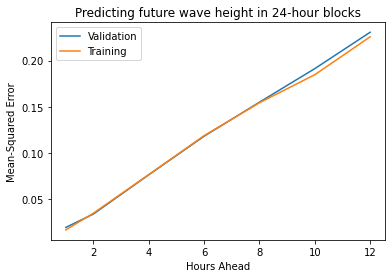

In [23]:
hrs_ahead = [1,2,4,6,8,10,12]
val_mse = [mse24_1, mse24_2, mse24_4, mse24_6, mse24_8, mse24_10, mse24_12]
training_mse = [mse24_1_train, mse24_2_train, mse24_4_train, mse24_6_train, mse24_8_train, mse24_10_train, mse24_12_train]
plt.figure('24hr mse')
plt.plot(hrs_ahead, val_mse, label='Validation')
plt.plot(hrs_ahead, training_mse, label='Training')
plt.xlabel('Hours Ahead')
plt.ylabel('Mean-Squared Error')
plt.title('Predicting future wave height in 24-hour blocks')
plt.legend()


In [25]:
# Ugly messy
X12_1_train, X12_1_test, Y12_1_train, Y12_1_test = train_test_split(X12_1, Y12_1, test_size=0.33, random_state=42)
mod12_1 = ml.train_ridge(input_features=X12_1_train, target_feature=Y12_1_train, c_value= 0.1)

preds12_1 = mod12_1.predict(X12_1_test)
preds12_1_train = mod12_1.predict(X12_1_train)
mse12_1 = mtr.calculate_mse(pred = preds12_1, true = Y12_1_test)
mse12_1_train = mtr.calculate_mse(pred = preds12_1_train, true = Y12_1_train)


X12_2_train, X12_2_test, Y12_2_train, Y12_2_test = train_test_split(X12_2, Y12_2, test_size=0.33, random_state=42)
mod12_2 = ml.train_ridge(input_features=X12_2_train, target_feature=Y12_2_train, c_value= 0.1)

preds12_2 = mod12_2.predict(X12_2_test)
preds12_2_train = mod12_2.predict(X12_2_train)
mse12_2 = mtr.calculate_mse(pred = preds12_2, true = Y12_2_test)
mse12_2_train = mtr.calculate_mse(pred = preds12_2_train, true = Y12_2_train)

X12_4_train, X12_4_test, Y12_4_train, Y12_4_test = train_test_split(X12_4, Y12_4, test_size=0.33, random_state=42)
mod12_4 = ml.train_ridge(input_features=X12_4_train, target_feature=Y12_4_train, c_value= 0.1)

preds12_4 = mod12_4.predict(X12_4_test)
preds12_4_train = mod12_4.predict(X12_4_train)
mse12_4 = mtr.calculate_mse(pred = preds12_4, true = Y12_4_test)
mse12_4_train = mtr.calculate_mse(pred = preds12_4_train, true = Y12_4_train)


X12_6_train, X12_6_test, Y12_6_train, Y12_6_test = train_test_split(X12_6, Y12_6, test_size=0.33, random_state=42)
mod12_6 = ml.train_ridge(input_features=X12_6_train, target_feature=Y12_6_train, c_value= 0.1)

preds12_6 = mod12_6.predict(X12_6_test)
preds12_6_train = mod12_6.predict(X12_6_train)
mse12_6 = mtr.calculate_mse(pred = preds12_6, true = Y12_6_test)
mse12_6_train = mtr.calculate_mse(pred = preds12_6_train, true = Y12_6_train)

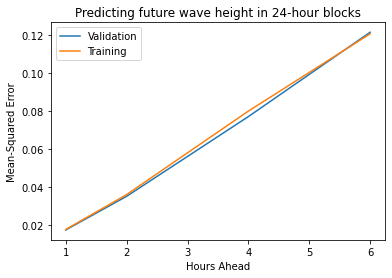

In [26]:
hrs_ahead = [1,2,4,6]
val_mse = [mse12_1, mse12_2, mse12_4, mse12_6]
training_mse = [mse12_1_train, mse12_2_train, mse12_4_train, mse12_6_train]
plt.figure('12hr mse')
plt.plot(hrs_ahead, val_mse, label='Validation')
plt.plot(hrs_ahead, training_mse, label='Training')
plt.xlabel('Hours Ahead')
plt.ylabel('Mean-Squared Error')
plt.title('Predicting future wave height in 12-hour blocks')
plt.legend()


In [28]:
# Ugly messy
X6_1_train, X6_1_test, Y6_1_train, Y6_1_test = train_test_split(X6_1, Y6_1, test_size=0.33, random_state=42)
mod6_1 = ml.train_ridge(input_features=X6_1_train, target_feature=Y6_1_train, c_value= 0.1)

preds6_1 = mod6_1.predict(X6_1_test)
preds6_1_train = mod6_1.predict(X6_1_train)
mse6_1 = mtr.calculate_mse(pred = preds6_1, true = Y6_1_test)
mse6_1_train = mtr.calculate_mse(pred = preds6_1_train, true = Y6_1_train)


X6_2_train, X6_2_test, Y6_2_train, Y6_2_test = train_test_split(X6_2, Y6_2, test_size=0.33, random_state=42)
mod6_2 = ml.train_ridge(input_features=X6_2_train, target_feature=Y6_2_train, c_value= 0.1)

preds6_2 = mod6_2.predict(X6_2_test)
preds6_2_train = mod6_2.predict(X6_2_train)
mse6_2 = mtr.calculate_mse(pred = preds6_2, true = Y6_2_test)
mse6_2_train = mtr.calculate_mse(pred = preds6_2_train, true = Y6_2_train)

X6_3_train, X6_3_test, Y6_3_train, Y6_3_test = train_test_split(X6_3, Y6_3, test_size=0.33, random_state=42)
mod6_3 = ml.train_ridge(input_features=X6_3_train, target_feature=Y6_3_train, c_value= 0.1)

preds6_3 = mod6_3.predict(X6_3_test)
preds6_3_train = mod6_3.predict(X6_3_train)
mse6_3 = mtr.calculate_mse(pred = preds6_3, true = Y6_3_test)
mse6_3_train = mtr.calculate_mse(pred = preds6_3_train, true = Y6_3_train)

X6_4_train, X6_4_test, Y6_4_train, Y6_4_test = train_test_split(X6_4, Y6_4, test_size=0.33, random_state=42)
mod6_4 = ml.train_ridge(input_features=X6_4_train, target_feature=Y6_4_train, c_value= 0.1)

preds6_4 = mod6_4.predict(X6_4_test)
preds6_4_train = mod6_4.predict(X6_4_train)
mse6_4 = mtr.calculate_mse(pred = preds6_4, true = Y6_4_test)
mse6_4_train = mtr.calculate_mse(pred = preds6_4_train, true = Y6_4_train)

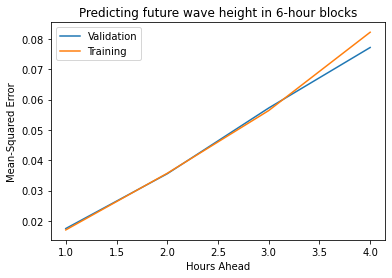

In [29]:
hrs_ahead = [1,2,3,4]
val_mse = [mse6_1, mse6_2, mse6_3, mse6_4]
training_mse = [mse6_1_train, mse6_2_train, mse6_3_train, mse6_4_train]
plt.figure('6hr mse')
plt.plot(hrs_ahead, val_mse, label='Validation')
plt.plot(hrs_ahead, training_mse, label='Training')
plt.xlabel('Hours Ahead')
plt.ylabel('Mean-Squared Error')
plt.title('Predicting future wave height in 6-hour blocks')
plt.legend()


In [30]:
# Ugly messy
X3_1_train, X3_1_test, Y3_1_train, Y3_1_test = train_test_split(X3_1, Y3_1, test_size=0.33, random_state=42)
mod3_1 = ml.train_ridge(input_features=X3_1_train, target_feature=Y3_1_train, c_value= 0.1)

preds3_1 = mod3_1.predict(X3_1_test)
preds3_1_train = mod3_1.predict(X3_1_train)
mse3_1 = mtr.calculate_mse(pred = preds3_1, true = Y3_1_test)
mse3_1_train = mtr.calculate_mse(pred = preds3_1_train, true = Y3_1_train)


X3_2_train, X3_2_test, Y3_2_train, Y3_2_test = train_test_split(X3_2, Y3_2, test_size=0.33, random_state=42)
mod3_2 = ml.train_ridge(input_features=X3_2_train, target_feature=Y3_2_train, c_value= 0.1)

preds3_2 = mod3_2.predict(X3_2_test)
preds3_2_train = mod3_2.predict(X3_2_train)
mse3_2 = mtr.calculate_mse(pred = preds3_2, true = Y3_2_test)
mse3_2_train = mtr.calculate_mse(pred = preds3_2_train, true = Y3_2_train)

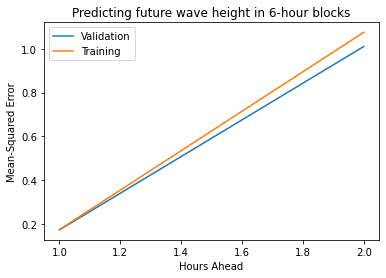

In [31]:
hrs_ahead = [1,2]
val_mse = [mse3_1, mse3_2]
training_mse = [mse3_1_train, mse3_2_train]
plt.figure('3hr mse')
plt.plot(hrs_ahead, val_mse, label='Validation')
plt.plot(hrs_ahead, training_mse, label='Training')
plt.xlabel('Hours Ahead')
plt.ylabel('Mean-Squared Error')
plt.title('Predicting future wave height in 3-hour blocks')
plt.legend()

In [ ]:
# Ugly messy
X2_1_train, X2_1_test, Y2_1_train, Y2_1_test = train_test_split(X2_1, Y2_1, test_size=0.33, random_state=42)
mod2_1 = ml.train_ridge(input_features=X2_1_train, target_feature=Y2_1_train, c_value= 0.1)

preds2_1 = mod2_1.predict(X2_1_test)
preds2_1_train = mod2_1.predict(X2_1_train)
mse2_1 = mtr.calculate_mse(pred = preds2_1, true = Y2_1_test)
mse2_1_train = mtr.calculate_mse(pred = preds2_1_train, true = Y2_1_train)